# Wasserstein GAN for Faces

## Imports & Setup

In [ ]:
from google.colab import drive

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, RandomRotation
from torchvision import datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import random
from statistics import mean

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('This Computation is running on {}'.format(device))
drive.mount('/content/drive')

This Computation is running on cuda:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Parameter

In [ ]:
BATCH_SIZE = 32
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 7
CLIP_THRESHOLD = 0.01
IMAGE_SIZE = 32
CHANNELS = 3
NOISE_SIZE = 100
LABEL_SMOOTHING = 0.1

DATASET = 'FACES' #FACES #MNIST
CMAP = 'gray'

def smooth():
  return np.random.normal(LABEL_SMOOTHING,0.01)

## Load Data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


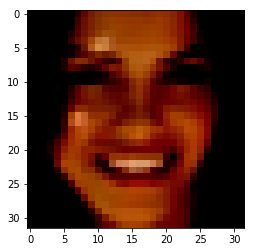

Loaded 787 images with batch size 32, 3 channels and 32*32 size


In [ ]:
if DATASET == 'MNIST':

  transform = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),transforms.Grayscale(),transforms.ToTensor(),transforms.Normalize((0.4163,), (0.8668,))])
  data = torchvision.datasets.MNIST('./data',transform=transform,download=True)

  init_filled = False
  for i, content in enumerate(data):
    data, label = content
    if label == 3:
      if not init_filled:
        subdata = data.clone().detach().view(1,CHANNELS,IMAGE_SIZE,IMAGE_SIZE)
        init_filled = True
        continue
      subdata = torch.cat((subdata, data.clone().detach().view(1,CHANNELS,IMAGE_SIZE,IMAGE_SIZE)),-4)
  data = subdata

elif DATASET == 'FACES':
  #(0.5180,), (0.1933,)
  if CHANNELS == 1:
    transform = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),transforms.Grayscale(),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
  else:
    transform = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),transforms.RandomRotation((90,90)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
  data = torchvision.datasets.ImageFolder('drive/My Drive/Limebit GmbH/IT/Colab Notebooks/data/utk_faces/female_european/adults',transform=transform)


  init_filled = False
  for i, content in enumerate(data):
    data, label = content
    if i==0:
      subdata = data.clone().detach().view(1,CHANNELS,IMAGE_SIZE,IMAGE_SIZE)
      continue
    subdata = torch.cat((subdata, torch.tensor(data).view(1,CHANNELS,IMAGE_SIZE,IMAGE_SIZE)),-4)
  data = subdata

elif DATASET == 'CIFAR':

  transform = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),transforms.Grayscale(),transforms.ToTensor(),transforms.Normalize((0.4774,), (0.2389,))])
  data = torchvision.datasets.CIFAR10('./data',transform=transform,download=True)

  init_filled = False
  for i, content in enumerate(data):
    data, label = content
    if label == 7:
      if not init_filled:
        subdata = data.clone().detach().view(1,CHANNELS,IMAGE_SIZE,IMAGE_SIZE)
        init_filled = True
        continue
      subdata = torch.cat((subdata, data.clone().detach().view(1,CHANNELS,IMAGE_SIZE,IMAGE_SIZE)),-4)
  data = subdata


dataloader = torch.utils.data.DataLoader(data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

DATA_AMOUNT = len(data)
INPUT_DIM=CHANNELS*IMAGE_SIZE*IMAGE_SIZE
sample_image = next(iter(dataloader))[0].squeeze()
plt.imshow(np.transpose(sample_image),cmap=CMAP)
plt.show()
print('Loaded {} images with batch size {}, {} channels and {}*{} size'.format(DATA_AMOUNT,BATCH_SIZE,CHANNELS,IMAGE_SIZE,IMAGE_SIZE))

In [ ]:
print(data.mean())
print(data.std())
print(data.min())
print(data.max())
print(sample_image.min())
print(sample_image.max())

tensor(-0.0311)
tensor(0.4819)
tensor(-1.)
tensor(1.)
tensor(-1.)
tensor(0.8745)


## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.4)

        self.conv1 = nn.Conv2d(CHANNELS,32,kernel_size=5,stride=2,padding=2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=5,stride=2,padding=2)
        self.conv3 = nn.Conv2d(64,128,kernel_size=5,stride=2,padding=2)
        self.conv4 = nn.Conv2d(128,3,kernel_size=5,stride=1,padding=2)
        self.fc1 = nn.Linear(int((3/64)*IMAGE_SIZE**2),1)

    def forward(self, x):

        x = self.activation(self.conv1(x))
        x = self.dropout(x)
        x = self.activation(self.conv2(x))
        x = self.dropout(x)
        x = self.activation(self.conv3(x))
        x = self.dropout(x)
        x = self.activation(self.conv4(x))
        x = self.dropout(x)
        x = x.view(BATCH_SIZE,-1)
        x = self.fc1(x)

        return x.squeeze()

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.activation = nn.LeakyReLU()
        self.end_activation = nn.Tanh()

        self.init_image_size = int(IMAGE_SIZE/4)

        self.fc1 = nn.Linear(NOISE_SIZE,8*IMAGE_SIZE**2)
        self.fc1_bn = nn.BatchNorm2d(128,momentum=0.8)
        self.us1 = nn.Upsample(scale_factor=2)

        self.conv1 = nn.Conv2d(128,128,kernel_size=5,stride=1,padding=2)
        self.conv1_bn = nn.BatchNorm2d(128,momentum=0.8)

        self.us2 = nn.Upsample(scale_factor=2)

        self.conv2 = nn.Conv2d(128,64,kernel_size=5,stride=1,padding=2)
        self.conv2_bn = nn.BatchNorm2d(64,momentum=0.8)

        self.conv3 = nn.Conv2d(64,32,kernel_size=5,stride=1,padding=2)
        self.conv3_bn = nn.BatchNorm2d(32,momentum=0.8)

        self.conv4 = nn.Conv2d(32,CHANNELS,kernel_size=5,stride=1,padding=2)


    def forward(self, x):

        x = self.fc1(x)
        x = x.view(-1,128,self.init_image_size,self.init_image_size)
        x = self.activation(self.fc1_bn(x))
        x = x.view(-1,128,self.init_image_size,self.init_image_size)
        x = self.us1(x)
        x = self.activation(self.conv1_bn(self.conv1(x)))
        x = self.us2(x)
        x = self.activation(self.conv2_bn(self.conv2(x)))
        x = self.activation(self.conv3_bn(self.conv3(x)))
        x = self.end_activation(self.conv4(x))

        return x.squeeze()

## Train Models

In [ ]:
def train_disc():

    for p in disc.parameters(): # reset requires_grad
      p.requires_grad = True

    optimizer_disc.zero_grad()

    #train on real images
    input = next(iter(dataloader)).cuda()
    pred_real = disc(input)
    error_real.append(pred_real.mean().item())
    pred_real.backward(torch.ones(size=(BATCH_SIZE,)).float().cuda(),retain_graph=True)

    input = gen(torch.from_numpy(np.random.normal(0, 1, (BATCH_SIZE, NOISE_SIZE))).float().cuda()).view(BATCH_SIZE,CHANNELS,IMAGE_SIZE,IMAGE_SIZE)
    input.required_grad = False
    pred_fake = disc(input)
    error_fake.append(pred_fake.mean().item())
    pred_fake.backward(-torch.ones(size=(BATCH_SIZE,)).float().cuda(),retain_graph=True)

    optimizer_disc.step()

    if CLIP_THRESHOLD != False:
      #clips weights accordingly with 1-Lipschitz constraint
      for layer in [module for module in disc.modules()]:
        try:
          layer.weight.data = torch.clamp(layer.weight.data,-CLIP_THRESHOLD,CLIP_THRESHOLD)
        except:
          pass

def train_gen():
    for p in disc.parameters():
      p.requires_grad = False
    optimizer_gen.zero_grad()

    input = gen(torch.from_numpy(np.random.normal(0, 1, (BATCH_SIZE, NOISE_SIZE))).float().cuda()).view(BATCH_SIZE,CHANNELS,IMAGE_SIZE,IMAGE_SIZE)
    pred_fake = disc(input)
    pred_fake.backward(torch.ones(size=(BATCH_SIZE,)).float().cuda(),retain_graph=True)

    optimizer_gen.step()


## Training Initialization

In [ ]:
disc = Discriminator().cuda()
gen = Generator().cuda()

optimizer_disc = optim.RMSprop(disc.parameters(),lr=0.00005)
optimizer_gen = optim.RMSprop(gen.parameters(),lr=0.00005)

error_fake = []
error_real = []

## Run Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #0, time since start 20.38s


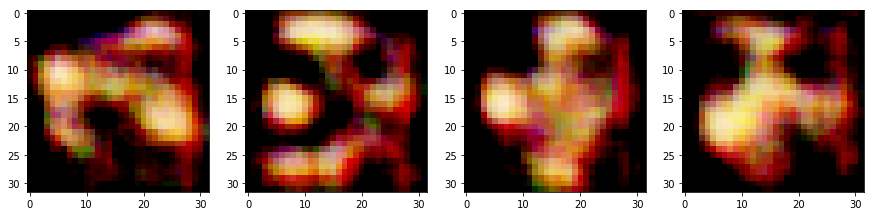

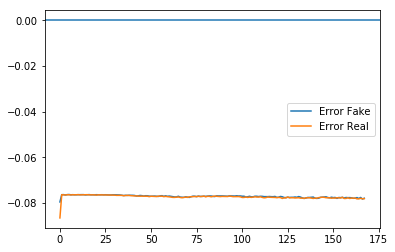


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #10, time since start 230.27s


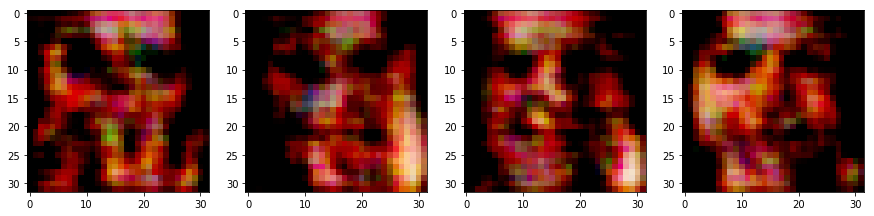

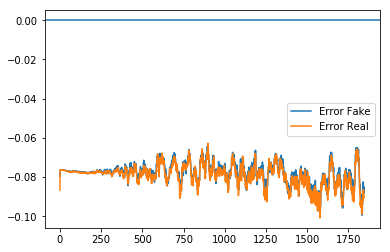


------



Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-g0l1jnsj'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #20, time since start 437.89s


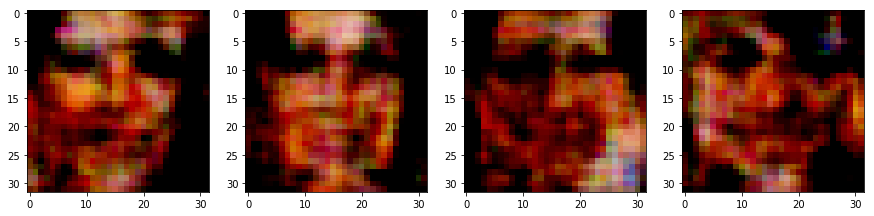

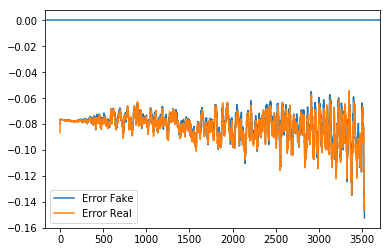


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #30, time since start 648.65s


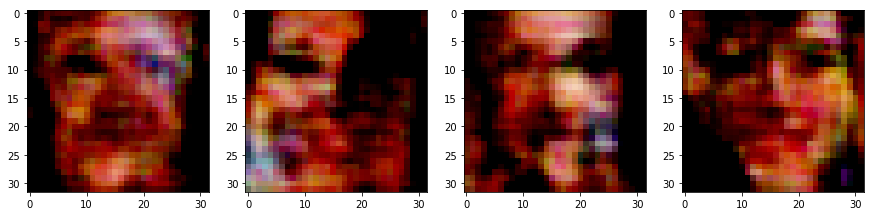

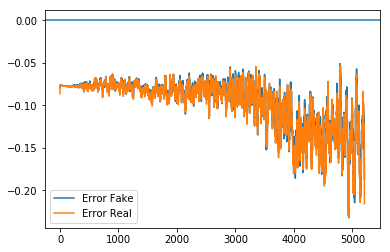


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #40, time since start 860.43s


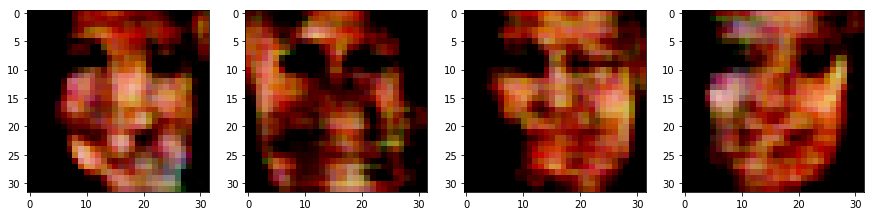

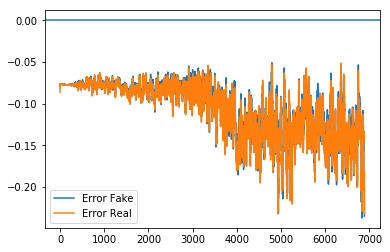


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #50, time since start 1066.03s


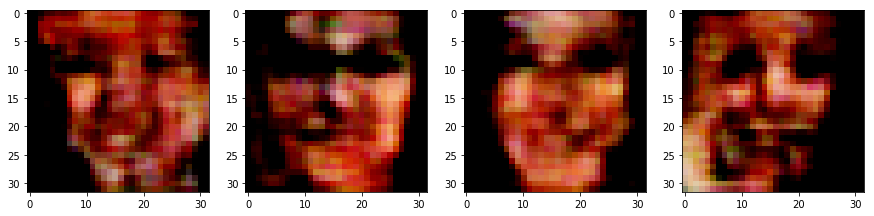

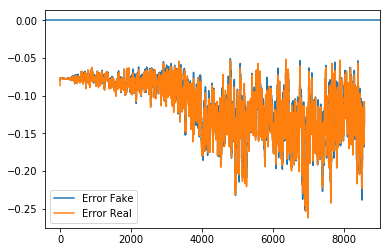


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #60, time since start 1278.24s


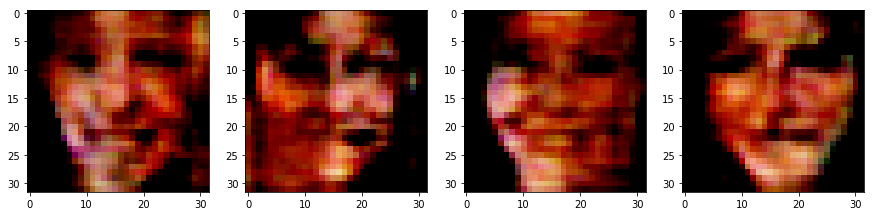

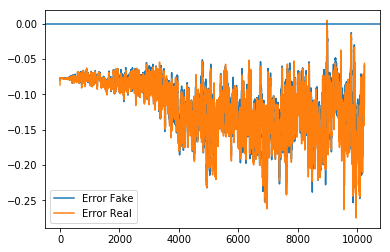


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #70, time since start 1485.09s


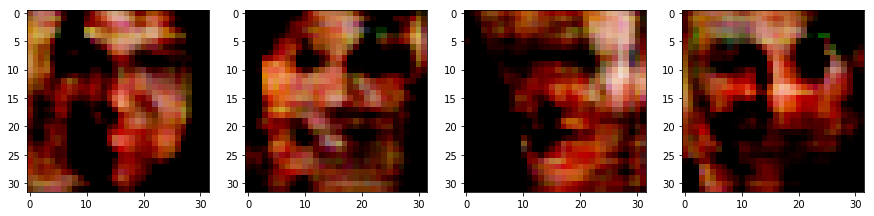

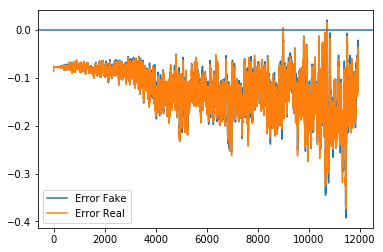


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #80, time since start 1697.06s


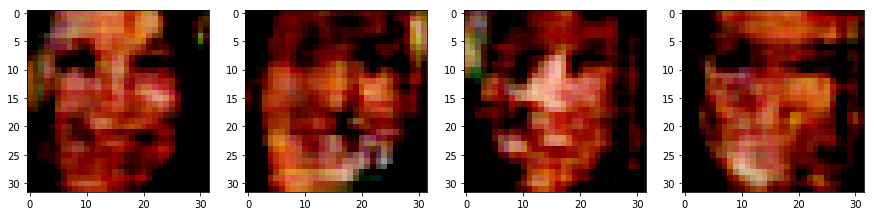

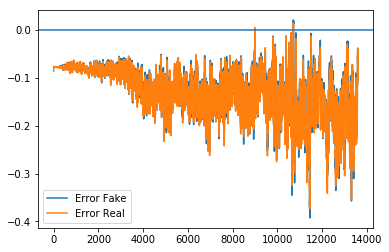


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #90, time since start 1907.17s


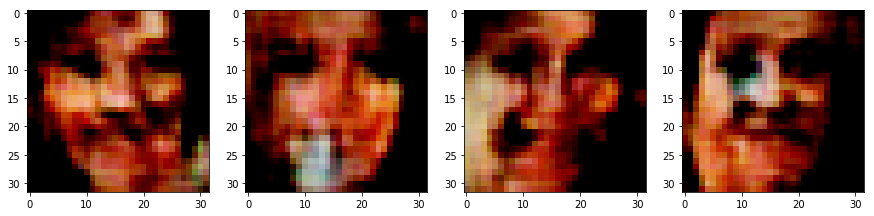

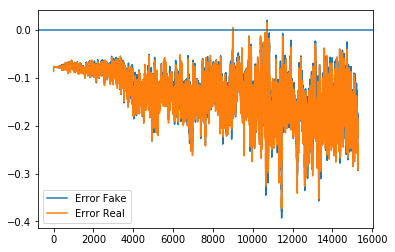


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #100, time since start 2127.6s


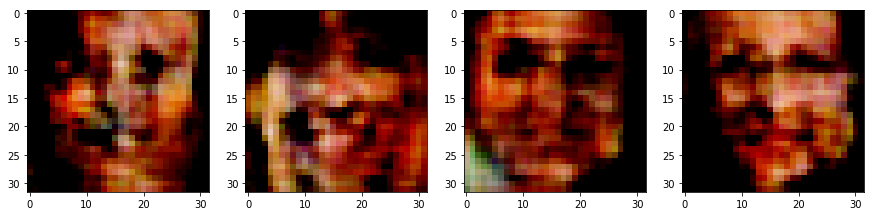

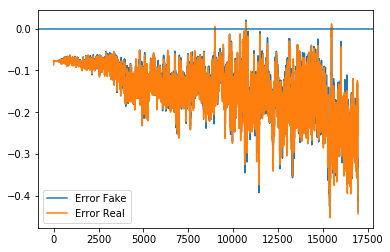


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #110, time since start 2339.88s


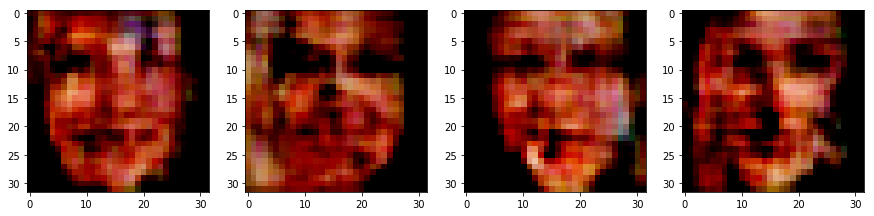

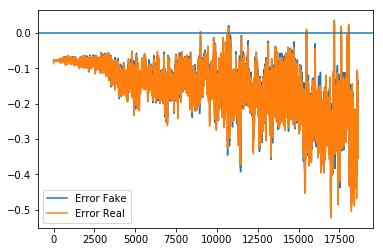


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #120, time since start 2551.7s


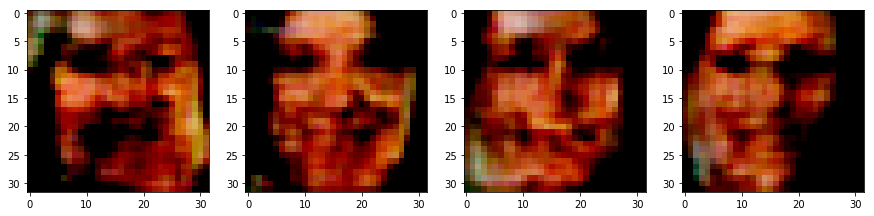

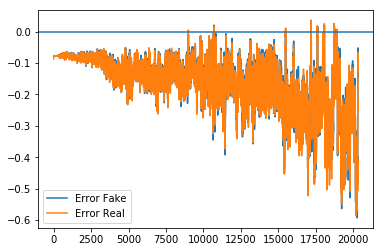


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #130, time since start 2760.78s


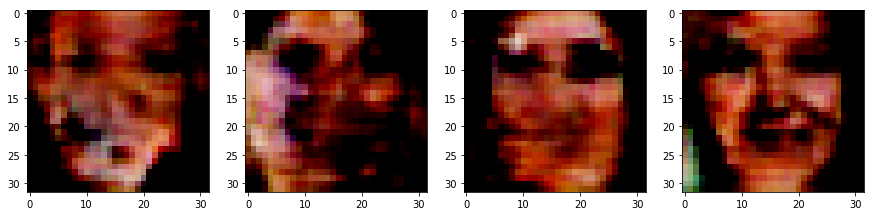

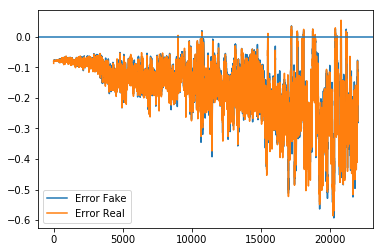


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #140, time since start 2966.4s


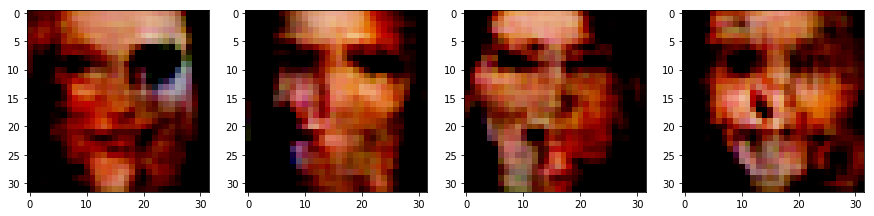

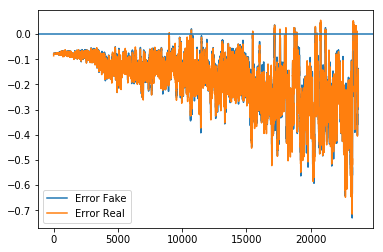


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #150, time since start 3174.94s


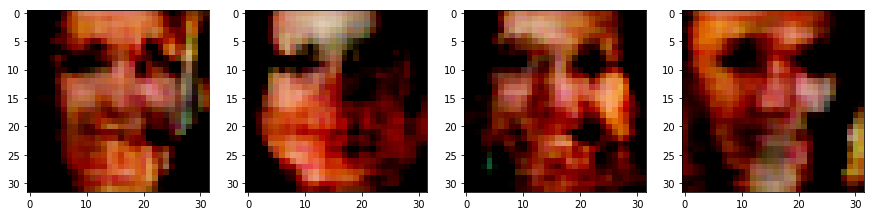

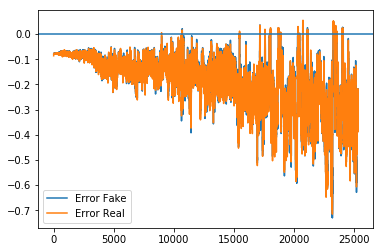


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #160, time since start 3383.31s


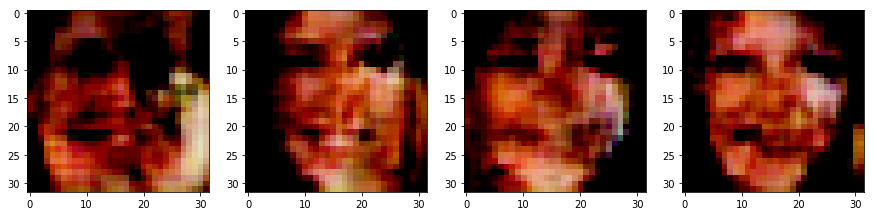

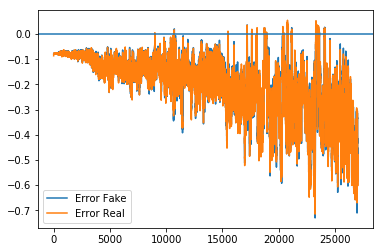


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #170, time since start 3595.79s


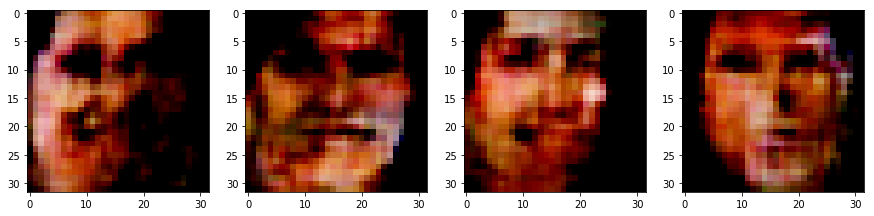

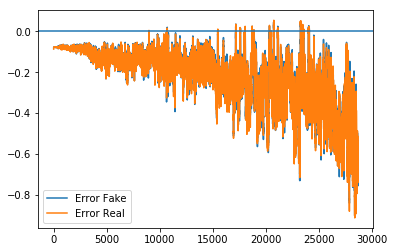


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #180, time since start 3809.56s


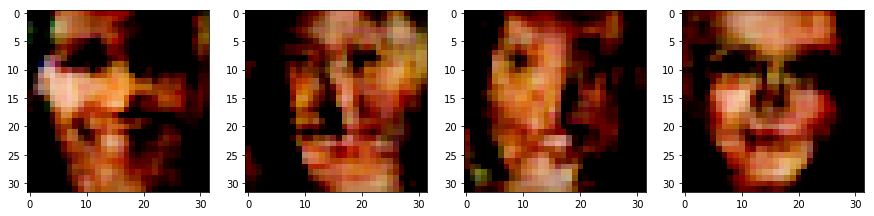

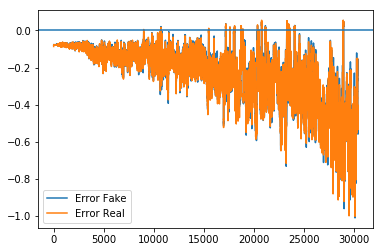


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #190, time since start 4022.6s


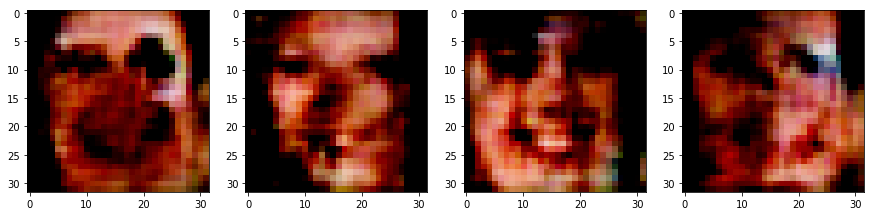

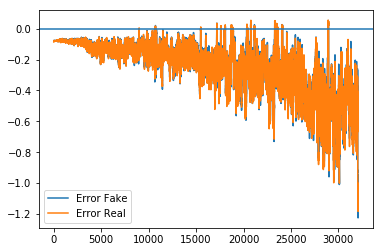


------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch #200, time since start 4236.94s


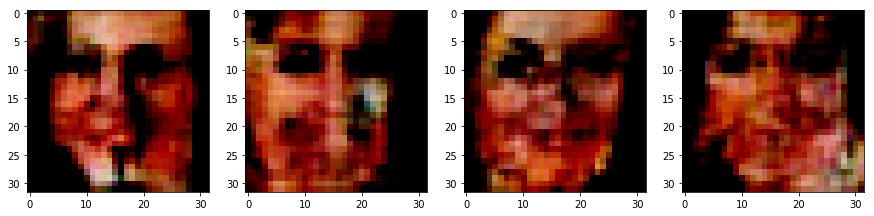

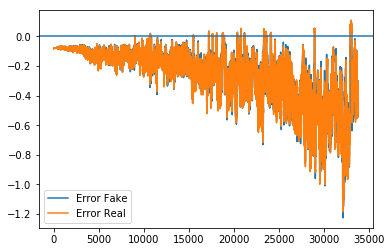


------



Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable


Epoch #210, time since start 4461.23s


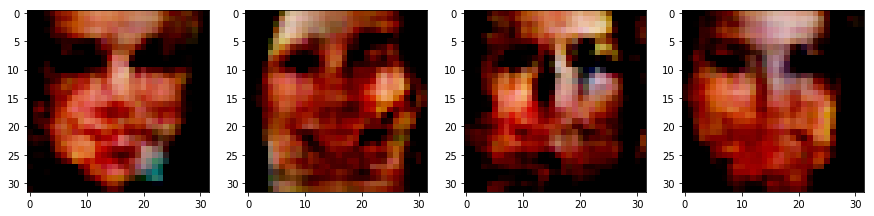

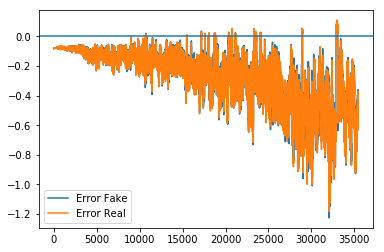


------



Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable
Exception ignored when trying to write to the signal wakeup fd:
BlockingIOError: [Errno 11] Resource temporarily unavailable


KeyboardInterrupt: ignored

In [ ]:
start_time = time.time()
for epoch in tnrange(EPOCHS, desc='Epochs',unit='Epoch'):

  #for i in tnrange(data_amount//batch_size, desc='Batches',unit='Batch',leave=False):
  for i in range(DATA_AMOUNT//BATCH_SIZE):
    for i in range(N_CRITIC):
      train_disc()
    train_gen()

  if epoch%10 == 0:
    print('Epoch #{}, time since start {}s'.format(epoch,round(time.time()-start_time,2)))
    fig, axes = plt.subplots(1,4,figsize=(15,5))
    for i in range(4):
      fake = gen(torch.tensor(np.random.normal(0, 1, (1, NOISE_SIZE))).float().cuda()).detach().cpu().squeeze()
      axes[i].imshow(np.transpose(fake),cmap=CMAP)
    plt.show()
    plt.plot(error_fake,label='Error Fake')
    plt.plot(error_real,label='Error Real')
    plt.axhline(0)
    plt.legend()
    plt.show()
    print()
    print("------")
    print()

## Check Resuls

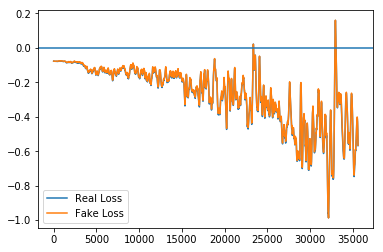

In [ ]:
from scipy.signal import savgol_filter

plt.plot(savgol_filter(error_real, 301, 3),label='Real Loss')
plt.plot(savgol_filter(error_fake, 301, 3),label='Fake Loss')
plt.axhline(0)
plt.legend()
plt.show()

## Plot some Random Generator Output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


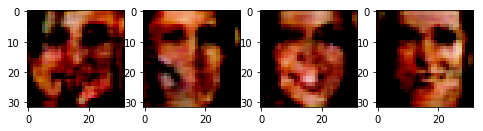

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(8,3))
fakes = []
for i in range(4):
  fake = gen(torch.tensor(np.random.normal(0, 1, (1, NOISE_SIZE))).float().cuda()).detach().cpu().squeeze()
  fakes.append(fake)
  axes[i].imshow(np.transpose(fake),cmap=CMAP)
plt.show()

In [ ]:
save = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


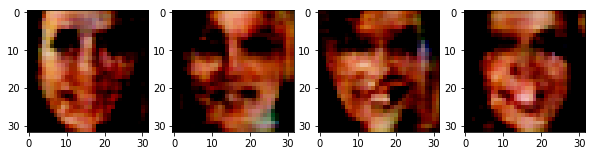

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(10,4))
for i, fake in enumerate(save):
  axes[i].imshow(np.transpose(fake),cmap=CMAP)
plt.show()

In [ ]:
torch.save({
            'epoch': 210,
            'model_state_dict': disc.state_dict(),
            'optimizer_state_dict': optimizer_disc.state_dict()
            }, 'critic_faces')

torch.save({
            'epoch': 210,
            'model_state_dict': gen.state_dict(),
            'optimizer_state_dict': optimizer_gen.state_dict()
            }, 'generator_faces')